In [1]:
import pandas as pd
import glob
import os
import sys

print("--- CSV 파일 통합, 전치 후, 하나의 컬럼으로 재구성 스크립트 시작 ---")

# 1. 파일 경로 목록 설정
file_paths = [
    '../../../버전1(top60)/modeling/성능지표',
    '../../../버전2(SPY)/modeling/성능지표'
]

# 2. DataFrame들을 저장할 리스트 초기화
dataframes_to_concat = []

print("=== 파일 로드 시작 ===")
# 3. 각 경로를 반복하며 CSV 파일 로드 및 리스트에 추가 (이전 코드와 동일)
for path in file_paths:
    if not os.path.isdir(path):
        print(f"⚠️ 경고: 지정된 경로를 찾을 수 없습니다: {path}")
        continue
        
    all_csv_files = glob.glob(os.path.join(path, '*.csv'))
    print(f"\n📁 경로 검색 중: {path}")

    for file_name_with_path in all_csv_files:
        try:
            file_name_full = os.path.basename(file_name_with_path)
            
            # CSV 파일을 Pandas DataFrame으로 읽기 (인덱스 없음)
            df = pd.read_csv(file_name_with_path, index_col=None, encoding='utf-8')
            
            dataframes_to_concat.append(df)
            print(f"✅ 성공적으로 로드됨: {file_name_full}")
            
        except Exception as e:
            print(f"❌ 파일 로드 중 오류 발생 ({file_name_with_path}): {e}")

--- CSV 파일 통합, 전치 후, 하나의 컬럼으로 재구성 스크립트 시작 ---
=== 파일 로드 시작 ===

📁 경로 검색 중: ../../../버전1(top60)/modeling/성능지표
✅ 성공적으로 로드됨: Top60_GRU_지표.CSV
✅ 성공적으로 로드됨: Top60_LightGBM_지표.csv
✅ 성공적으로 로드됨: Top60_LSTM_지표.csv
✅ 성공적으로 로드됨: Top60_XGBoost_지표.csv
✅ 성공적으로 로드됨: Top60_다중회귀_지표.csv

📁 경로 검색 중: ../../../버전2(SPY)/modeling/성능지표
✅ 성공적으로 로드됨: SPY_GRU_지표.CSV
✅ 성공적으로 로드됨: SPY_LightGBM_지표.csv
✅ 성공적으로 로드됨: SPY_LSTM_지표.csv
✅ 성공적으로 로드됨: SPY_XGBoost_지표.csv
✅ 성공적으로 로드됨: SPY_다중회귀_지표.csv


In [2]:
import pandas as pd
import glob
import os
import sys

# ... (4. 파일 로드 및 통합 부분은 동일) ...

# 4. 모든 DataFrame의 내용물만 하나로 합치기
if not dataframes_to_concat:
    print("\n⚠️ 로드된 CSV 파일이 없어 통합할 데이터가 없습니다. 스크립트를 종료합니다.")
    sys.exit()

# 수직으로 통합 (총 4행)
final_combined_df_pure = pd.concat(dataframes_to_concat, ignore_index=True)

# 5. 통합된 DataFrame 전치 (행과 열을 바꿈)
transposed_df = final_combined_df_pure.T

# 6. 모든 수치 데이터를 하나의 Series로 재구성 (이전 코드와 동일)
combined_series = transposed_df.stack()

# stack()의 결과는 MultiIndex이므로, 원래 인덱스만 추출합니다.
final_values = combined_series.values
final_index = [idx[0] for idx in combined_series.index]

# 7. 새로운 DataFrame 생성 및 컬럼 분류 (핵심 수정 부분)
temp_df = pd.DataFrame({
    'Metric_Name': final_index,
    'Value': final_values
})

# Step 7-2: 'Metric_Name'에서 모델/데이터셋 이름(예: '60_GRU', 'top60_LSTM', 'SPY_GRU')을 추출하여
# 새로운 인덱스로 사용합니다.
# 'RMSE', 'MAE' 또는 'R2'를 기준으로 분리합니다.
# 인덱스가 '60_GRU_RMSE'라면 -> 모델명은 '60_GRU'가 됩니다.
temp_df['Model'] = temp_df['Metric_Name'].apply(
    lambda x: x.replace('_RMSE', '').replace('_MAE', '').replace('_R2', '')
)

# Step 7-3: 'Metric_Name'에 'RMSE', 'MAE', 또는 'R2'가 포함되어 있는지 확인하여 컬럼 이름을 지정합니다.
temp_df['Type'] = temp_df['Metric_Name'].apply(
    lambda x: 'RMSE' if 'RMSE' in x else (
        'MAE' if 'MAE' in x else (
            'R2' if 'R2' in x else 'Other'
        )
    )
)

# Step 7-4: 피벗 테이블(Pivot Table)을 사용하여 'Model'을 새로운 인덱스로, 'Type'을 새로운 컬럼으로 만듭니다.
# 이는 데이터프레임을 재구성하여 'RMSE', 'MAE' 및 'R2' 값을 해당 모델 행에 배치합니다.
final_df = temp_df.pivot_table(
    index='Model', 
    columns='Type', 
    values='Value', 
    aggfunc='first' # 각 모델/타입 조합에 값이 하나만 있다고 가정하고 'first' 사용
)

# Step 7-5: 컬럼 순서를 'RMSE', 'MAE', 'R2' 순서로 확정합니다.
target_columns = ['RMSE', 'MAE', 'R2'] 
present_columns = [col for col in target_columns if col in final_df.columns]

# 'Other' 컬럼이 있다면 순서에 포함시킵니다.
if 'Other' in final_df.columns:
    present_columns.append('Other')

# 정의된 순서로 컬럼을 재정렬하고, 존재하지 않는 컬럼은 무시합니다.
final_df = final_df[present_columns].fillna(0) # NaN을 0으로 채움

# 인덱스 이름 설정 (선택 사항)
final_df.index.name = 'Model_Identifier'

print("\n--- ✅ 최종 분류 및 재구성된 DataFrame ---")
print("[ 최종 DataFrame 미리보기 ]")
print(final_df)
print(f"\n총 행 개수: {len(final_df)} (모델 개수)")
print(f"총 컬럼 개수: {len(final_df.columns)} (지표 개수)")


--- ✅ 최종 분류 및 재구성된 DataFrame ---
[ 최종 DataFrame 미리보기 ]
Type                  RMSE       MAE        R2
Model_Identifier                              
SPY_GRU           0.013174  0.007314  0.969366
SPY_LSTM          0.012224  0.007520  0.971163
SPY_LightGBM      0.013387  0.007509  0.967035
SPY_XGBoost       0.014115  0.008295  0.963353
SPY_다중회귀          0.011876  0.006421  0.974056
Top60_GRU         0.013186  0.007370  0.969310
Top60_LSTM        0.012355  0.007859  0.968724
Top60_LightGBM    0.013344  0.007519  0.967248
Top60_XGBoost     0.013318  0.007761  0.967375
Top60_다중회귀        0.012473  0.006747  0.970018

총 행 개수: 10 (모델 개수)
총 컬럼 개수: 3 (지표 개수)


In [3]:
# vscode 버전 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 환경 기준 나눔고딕 폰트 경로
font_path = 'c:/WINDOWS/Fonts/MALGUN.TTF'

# 폰트 등록
fm.fontManager.addfont(font_path)

# matplotlib에 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

C:\Users\ssginc10\AppData\Local\Temp\ipykernel_5764\2050801893.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ssginc10\AppData\Local\Temp\ipykernel_5764\2050801893.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ssginc10\AppData\Local\Temp\ipykernel_5764\2050801893.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


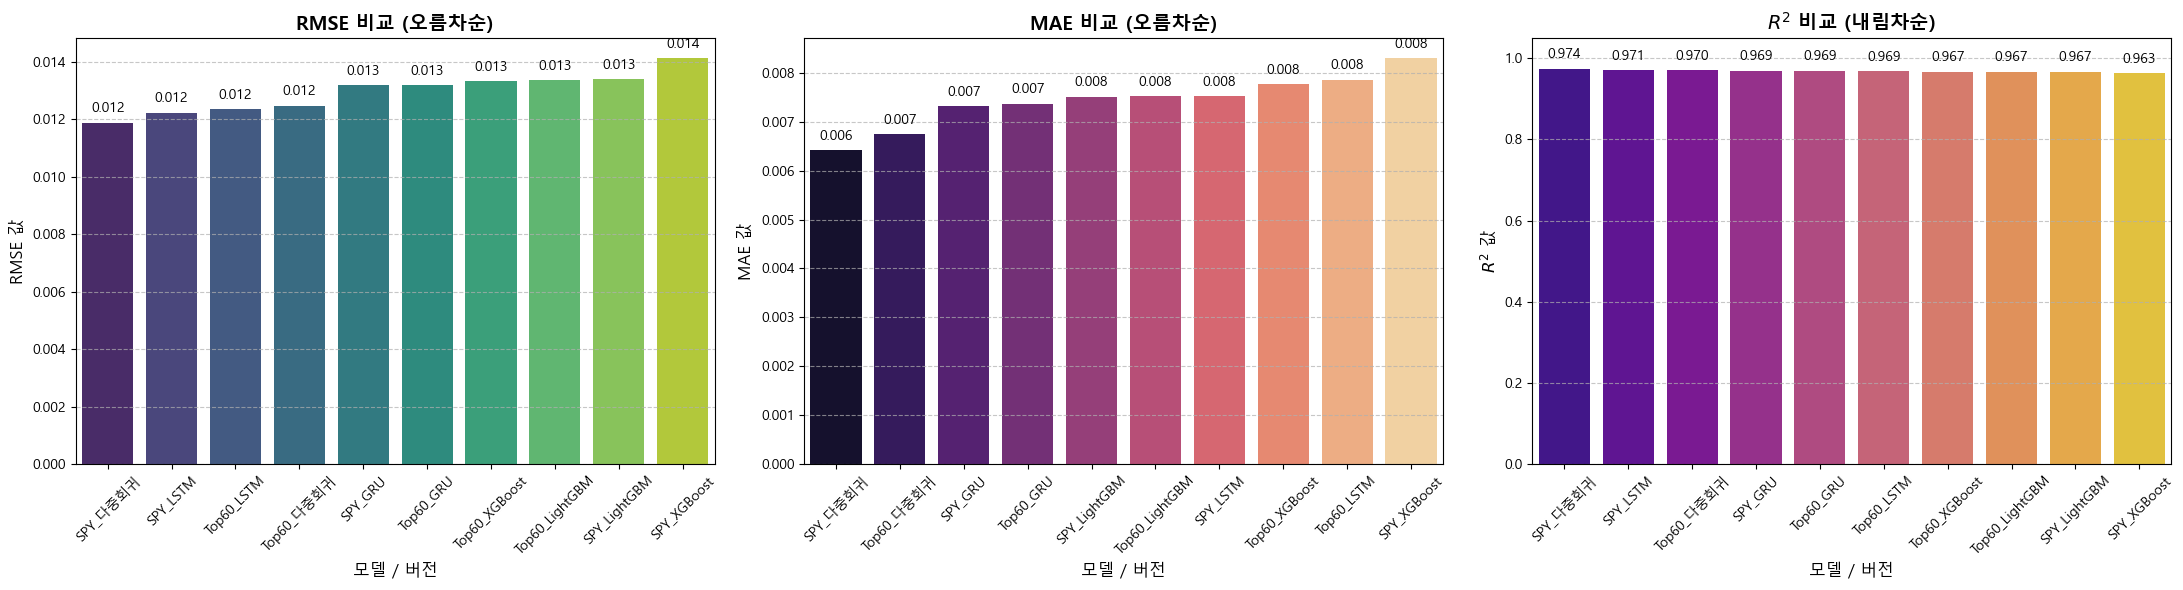

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# final_df가 정의되어 있다고 가정합니다. (이전 단계에서 생성된 DataFrame)
# final_df는 'RMSE', 'MAE', 'R2' 컬럼을 포함하고 있어야 합니다.

# -------------------------------------------------------------
# 1. 그래프 정렬을 위한 인덱스 준비 (MAE 추가)
# -------------------------------------------------------------

# RMSE 오름차순 정렬 (값이 낮을수록 좋으므로)
rmse_order = final_df['RMSE'].sort_values(ascending=True).index

# MAE 오름차순 정렬 (값이 낮을수록 좋으므로)
mae_order = final_df['MAE'].sort_values(ascending=True).index

# R2 내림차순 정렬 (값이 높을수록 좋으므로)
r2_order = final_df['R2'].sort_values(ascending=False).index

# -------------------------------------------------------------
# 2. 세 개의 서브플롯(Subplots)을 가진 피규어 생성 (1x3으로 변경)
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) # figsize를 가로로 늘려 3개 그래프 수용

# -------------------------------------------------------------
# 3. RMSE 비교 그래프 (왼쪽 서브플롯: axes[0]) - 오름차순 정렬 적용
# -------------------------------------------------------------
sns.barplot(
    x=final_df.index,
    y=final_df['RMSE'],
    ax=axes[0],
    palette="viridis",
    order=rmse_order 
)
axes[0].set_title('RMSE 비교 (오름차순)', fontsize=14, weight='bold')
axes[0].set_xlabel('모델 / 버전', fontsize=12)
axes[0].set_ylabel('RMSE 값', fontsize=12)
axes[0].tick_params(axis='x', rotation=45) 
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 값 표시 (RMSE)
for i, p in enumerate(axes[0].patches):
    axes[0].annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 10), textcoords='offset points'
    )

# -------------------------------------------------------------
# 4. MAE 비교 그래프 (중앙 서브플롯: axes[1]) - 오름차순 정렬 적용 (새로 추가)
# -------------------------------------------------------------
sns.barplot(
    x=final_df.index,
    y=final_df['MAE'],
    ax=axes[1],
    palette="magma", # 새로운 색상 팔레트
    order=mae_order # MAE 오름차순 정렬 적용
)
axes[1].set_title('MAE 비교 (오름차순)', fontsize=14, weight='bold')
axes[1].set_xlabel('모델 / 버전', fontsize=12)
axes[1].set_ylabel('MAE 값', fontsize=12)
axes[1].tick_params(axis='x', rotation=45) 
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 값 표시 (MAE)
for i, p in enumerate(axes[1].patches):
    axes[1].annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 10), textcoords='offset points'
    )
    
# -------------------------------------------------------------
# 5. R2 비교 그래프 (오른쪽 서브플롯: axes[2]) - 내림차순 정렬 적용 (인덱스 변경)
# -------------------------------------------------------------
sns.barplot(
    x=final_df.index,
    y=final_df['R2'],
    ax=axes[2], # axes[2]로 변경
    palette="plasma",
    order=r2_order
)
axes[2].set_title('$R^2$ 비교 (내림차순)', fontsize=14, weight='bold')
axes[2].set_xlabel('모델 / 버전', fontsize=12)
axes[2].set_ylabel('$R^2$ 값', fontsize=12)
axes[2].tick_params(axis='x', rotation=45) 
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].set_ylim(0, 1.05) 

# 막대 위에 값 표시 (R2)
for i, p in enumerate(axes[2].patches):
    axes[2].annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 10), textcoords='offset points'
    )
    
# -------------------------------------------------------------
# 6. 레이아웃 조정 및 그래프 표시
# -------------------------------------------------------------
plt.tight_layout()
plt.show()